In [1]:
import sys
sys.path.insert(0, "/home/ubuntu")
import numpy as np
import os.path as osp
import matplotlib.pylab as plt

from latent_3d_points.src.ae_templates import mlp_architecture_ala_iclr_18, default_train_params
from latent_3d_points.src.point_net_ae import PointNetAutoEncoder

from latent_3d_points.src.autoencoder import Configuration as Conf
from latent_3d_points.src.neural_net import MODEL_SAVER_ID

from latent_3d_points.src.in_out import snc_category_to_synth_id, create_dir, PointCloudDataSet,\
        load_all_point_clouds_under_folder, pickle_data, unpickle_data

from latent_3d_points.src.general_utils import plot_3d_point_cloud
from latent_3d_points.src.tf_utils import reset_tf_graph

from latent_3d_points.src.vanilla_gan import Vanilla_GAN
from latent_3d_points.src.w_gan_gp import W_GAN_GP
from latent_3d_points.src.generators_discriminators import point_cloud_generator,mlp_discriminator, leaky_relu, conditional_point_cloud_generator


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
# Use to save Neural-Net check-points etc.
top_out_dir = '../data/'

# Top-dir of where point-clouds are stored.
top_in_dir = '../data/shape_net_core_uniform_samples_2048/'

experiment_name = 'raw_gan_incomplete'

n_pc_points = 2048                # Number of points per model.
bneck_size = 128                  # Bottleneck-AE size
ae_loss = 'chamfer'                   # Loss to optimize: 'emd' or 'chamfer'
# class_name = raw_input('Give me the class name (e.g. "chair"): ').lower()
class_name = 'chair'


# In[5]:



# all_pc_data = load_all_point_clouds_under_folder(class_dir, n_threads=8, file_ending='.ply', verbose=True)
train_pkl = unpickle_data('/home/ubuntu/latent_3d_points/data/missing_points_dataset/train_data.pkl')
train_data = next(train_pkl)

val_pkl = unpickle_data('/home/ubuntu/latent_3d_points/data/missing_points_dataset/val_data.pkl')
val_data = next(val_pkl)

print 'Shape of DATA =', train_data.point_clouds.shape


# Set GAN parameters.

# In[14]:


use_wgan = True     # Wasserstein with gradient penalty, or not?
n_epochs = 2000       # Epochs to train.

plot_train_curve = True
save_gan_model = True
saver_step = np.hstack([np.array([1, 5, 10]), np.arange(50, n_epochs + 1, 50)])

# If true, every 'saver_step' epochs we produce & save synthetic pointclouds.
save_synthetic_samples = True
# How many synthetic samples to produce at each save step.
n_syn_samples = train_data.num_examples

# Optimization parameters
init_lr = 0.0001
batch_size = 50
noise_params = {'mu':0, 'sigma': 0.2}
# noise_dim = 128
noise_dim = 1948 # incomplete shape: 2048 - 100 - 1948
beta = 0.5 # ADAM's momentum.

n_out = [n_pc_points, 3] # Dimensionality of generated samples.

discriminator = mlp_discriminator
# generator = point_cloud_generator
train_params = default_train_params() # not actually used
encoder, decoder, enc_args, dec_args = mlp_architecture_ala_iclr_18(n_pc_points, bneck_size)


conf = Conf(n_input = [1948, 3],
            loss = ae_loss,
            training_epochs = train_params['training_epochs'], # not actually used
            batch_size = train_params['batch_size'],
            denoising = train_params['denoising'],
            learning_rate = train_params['learning_rate'],
            train_dir = top_out_dir,
            loss_display_step = train_params['loss_display_step'],
            saver_step = train_params['saver_step'],
            z_rotate = train_params['z_rotate'],
            encoder = encoder,
            decoder = decoder,
            encoder_args = enc_args,
            decoder_args = dec_args,
            n_output = [2048, 3]
           )
conf.experiment_name = experiment_name
generator = conditional_point_cloud_generator

if save_synthetic_samples:
    synthetic_data_out_dir = osp.join(top_out_dir, 'OUT/synthetic_samples/', experiment_name)
    create_dir(synthetic_data_out_dir)

if save_gan_model:
    train_dir = osp.join(top_out_dir, 'OUT/raw_gan', experiment_name)
    create_dir(train_dir)

# In[15]:

reset_tf_graph()

if use_wgan:
    lam = 10
    disc_kwargs = {'b_norm': False}
    gan = W_GAN_GP(experiment_name, init_lr, lam, n_out, noise_dim,
                    discriminator, generator, conf,
                    disc_kwargs=disc_kwargs, beta=beta)

else:
    leak = 0.2
    disc_kwargs = {'non_linearity': leaky_relu(leak), 'b_norm': False}
    gan = Vanilla_GAN(experiment_name, init_lr, n_out, noise_dim,
                      discriminator, generator, beta=beta, disc_kwargs=disc_kwargs)

Shape of DATA = (5422, 3996, 3)
Building Encoder
encoder_conv_layer_0 conv params =  256 bnorm params =  128
Tensor("raw_gan_incomplete_1/generator/Relu:0", shape=(?, 1948, 64), dtype=float32)
output size: 124672 

encoder_conv_layer_1 conv params =  8320 bnorm params =  256
Tensor("raw_gan_incomplete_1/generator/Relu_1:0", shape=(?, 1948, 128), dtype=float32)
output size: 249344 

encoder_conv_layer_2 conv params =  16512 bnorm params =  256
Tensor("raw_gan_incomplete_1/generator/Relu_2:0", shape=(?, 1948, 128), dtype=float32)
output size: 249344 

encoder_conv_layer_3 conv params =  33024 bnorm params =  512
Tensor("raw_gan_incomplete_1/generator/Relu_3:0", shape=(?, 1948, 256), dtype=float32)
output size: 498688 

encoder_conv_layer_4 conv params =  32896 bnorm params =  256
Tensor("raw_gan_incomplete_1/generator/Relu_4:0", shape=(?, 1948, 128), dtype=float32)
output size: 249344 

Tensor("raw_gan_incomplete_1/generator/Max:0", shape=(?, 128), dtype=float32)
Building Decoder
decoder

In [4]:
model_path = '/home/ubuntu/latent_3d_points/data/OUT/raw_gan/raw_gan_incomplete'
epoch = 1050
gan.restore_model(model_path, epoch, verbose=False)



INFO:tensorflow:Restoring parameters from /home/ubuntu/latent_3d_points/data/OUT/raw_gan/raw_gan_incomplete/models.ckpt-1050


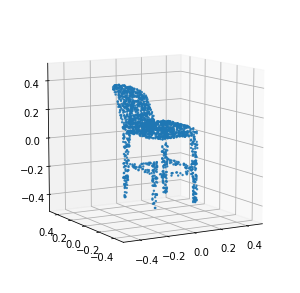

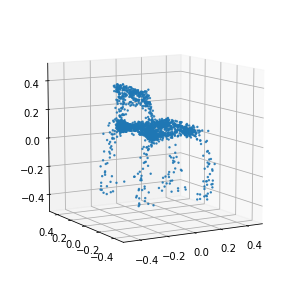

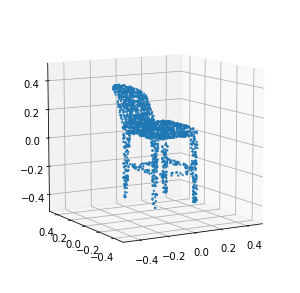

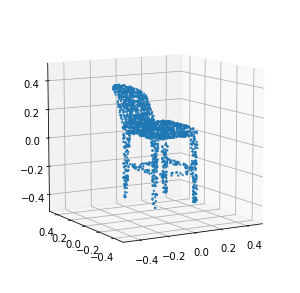

In [13]:
if save_synthetic_samples and epoch in saver_step:
    batch_i, _, _ = val_data.next_batch(10)
    inc, real = batch_i[:, :1948, :], batch_i[:, 1948:, :]
    syn_data = gan.generate(inc)
    
# for k in range(3):  # plot three (synthetic) random examples.
    
k = 1
plot_3d_point_cloud(inc[k][:, 0], inc[k][:, 1], inc[k][:, 2],\
                   in_u_sphere=True)
plot_3d_point_cloud(syn_data[k][:, 0], syn_data[k][:, 1], syn_data[k][:, 2],\
                   in_u_sphere=True)
plot_3d_point_cloud(real[k][:, 0], real[k][:, 1], real[k][:, 2],\
                   in_u_sphere=True)
    

(10, 2048, 3)


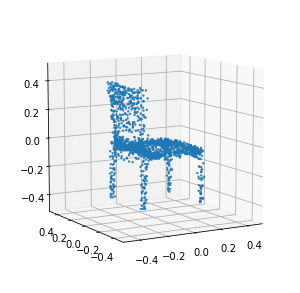

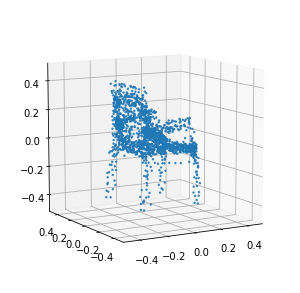

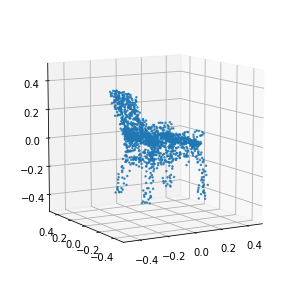

In [6]:
npy_file = "/home/ubuntu/latent_3d_points/data/OUT/synthetic_samples/raw_gan_incomplete/epoch_1050.npz"
syn_data_npz = np.load(npy_file)
syn_data = syn_data_npz['arr_0']
print(syn_data.shape)

for k in range(3):  # plot three (synthetic) random examples.
    plot_3d_point_cloud(syn_data[k][:, 0], syn_data[k][:, 1], syn_data[k][:, 2],\
                       in_u_sphere=True)